In [1]:
import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt
import faceted 
import scipy.stats as stats
from matplotlib.legend_handler import HandlerBase
import utils
import seaborn as sns
print("Computing Figure 1...... ")

Computing Figure 1...... 


/home/tarshish/micromamba/envs/zec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.set_plot_configs(plt, fsize=8)

In [3]:
results_dir = utils.get_path('results')
data = results_dir + '/ZECMIP_data.json'

print("Loading in ZECMIP data from data.json... ")
with open(data) as file:
    ZECMIP = json.load(file)
    
# convert data from lists to arrays
for model in ZECMIP.keys():
    for exp in ["750", "1000", "2000"]:
        if exp in ZECMIP[model].keys():
            for var in ZECMIP[model][exp].keys():
                ZECMIP[model][exp][var] = np.array(ZECMIP[model][exp][var])

Loading in ZECMIP data from data.json... 


In [4]:
with open(results_dir+"/fair/historical_zec.pkl", "rb") as file:                                                                            
    f = pickle.load(file)    

tcr = f.ebms.tcr
ecs = f.ebms.ecs

temperature = f.temperature.isel(layer=0, scenario=0)

Tzero = temperature.sel(timebounds=slice(1850,1900)).mean("timebounds")

Tze = temperature.sel(timebounds=2024)
Tf = temperature.sel(timebounds=3000)

Fze = f.forcing_sum.sel(timebounds=slice(2019,2024)).mean("timebounds").isel(scenario=0)
Ff = f.forcing_sum.sel(timebounds=3000).isel(scenario=0)

ZEC_div_Tze_exp_FaIR = (Tf - Tze)/Tze
ZEC_div_Tze_theory_FaIR = Ff/Fze/(tcr/ecs) - 1 

ZEC_div_Tze_exp_kde = stats.gaussian_kde(ZEC_div_Tze_exp_FaIR , bw_method="silverman")
sample_range = np.linspace(-1,1,1000)
ZEC_div_Tze_exp_kde_data = ZEC_div_Tze_exp_kde.evaluate(sample_range)

ecdf = stats.ecdf(ZEC_div_Tze_exp_FaIR).cdf
pos_ZEC_percent = (1-ecdf.evaluate(0))*100
pos_ZEC_percent = int(np.round(pos_ZEC_percent,decimals=0))

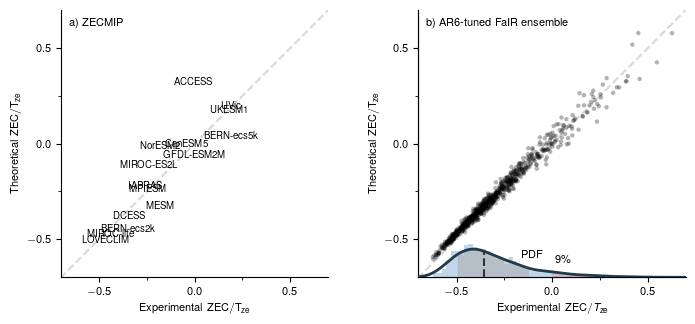

In [16]:
fig, axes = faceted.faceted(
    1, 2, sharex=False, sharey=False, width=7, aspect=1.0,
    top_pad=0.05, bottom_pad=0.4, right_pad=0.3,
    left_pad=0.65, internal_pad=1.2
)

ax1, ax2 = axes
ZEC_over_Tze_exps = []
ZEC_over_Tze_theories = []

for model in ZECMIP:
    exp = "1000"
    if exp in ZECMIP[model]:
        data = ZECMIP[model][exp]
        if 'ZEC_div_Tze_theory' in data:
            ZEC_div_Tze_theory = data["ZEC_div_Tze_theory"]
            ZEC_div_Tze_exp = data["ZEC_div_Tze_exp"]
            ZEC_over_Tze_exps.append(ZEC_div_Tze_exp)
            ZEC_over_Tze_theories.append(ZEC_div_Tze_theory)
            ax1.text(
                ZEC_div_Tze_exp, ZEC_div_Tze_theory, model,
                color="black", ha="center", va="center",
                alpha=1, fontsize=7
            )

d = np.linspace(-1, 1, 10)
ax1.plot(d, d, color='grey', linestyle='dashed', zorder=0, alpha=0.3)
ax1.set_xlabel(r"Experimental $\text{ZEC}/\text{T}_\text{ze}$")
ax1.set_ylabel(r"Theoretical $\text{ZEC}/\text{T}_\text{ze}$")
ax1.set_xticks([-.5, 0, .5])
ax1.set_yticks([-.5, 0, .5])
ax1.set_xticks([-.75, -.25, .25, .75], minor=True)
ax1.set_yticks([-.75, -.25, .25, .75], minor=True)
ax1.set_xlim(-0.7, 0.7)
ax1.set_ylim(-0.7, 0.7)
ax1.spines[['right', 'top']].set_visible(False)

# r_squared = np.corrcoef(ZEC_over_Tze_exps, ZEC_over_Tze_theories)[0, 1] ** 2
# ax1.text(
#     0.9, 0.9, r"$R^2$ = " + f"{r_squared:.2f}",
#     transform=ax1.transAxes, ha="left", va="center", color="black"
# )

#---------------- RHS plot ------------------------------

ax2.scatter(
    ZEC_div_Tze_exp_FaIR, ZEC_div_Tze_theory_FaIR,
    alpha=0.3, s=10, color="black", edgecolor="none"
)
ax2.plot(d, d, color='grey', linestyle='dashed', zorder=0, alpha=0.3)
ax2.set_xlabel(r"Experimental $\text{ZEC}/T_\text{ze}$")
ax2.set_xticks([-1, -.5, 0, .5, 1])
ax2.set_xticks([-.75, -.25, .25, .75], minor=True)
ax2.set_yticks([-1, -.5, 0, .5, 1])
ax2.set_yticks([-.75, -.25, .25, .75], minor=True)
ax2.set_ylim(-0.7, 0.7)
# r_squared = np.corrcoef(ZEC_div_Tze_exp_FaIR, ZEC_div_Tze_theory_FaIR)[0, 1] ** 2
# ax2.text(
#     0.9, 0.9, r"$R^2$ = " + f"{r_squared:.2f}",
#     transform=ax2.transAxes, ha="left", va="center", color="black"
# )

ax3 = ax2.twinx()
ax3.plot(sample_range, ZEC_div_Tze_exp_kde_data, color="#1f3b4d", zorder=3, linewidth=2)
ax3.hist(
    ZEC_div_Tze_exp_FaIR, density=True, bins=60, alpha=0.4,
    color="#6699cc", edgecolor="none", zorder=2
)
ax3.set_ylim(0, 23)
ax3.fill_between(
    sample_range[sample_range > 0], 0, ZEC_div_Tze_exp_kde_data[sample_range > 0],
    color='#f28e8e', zorder=2, alpha=0.4
)
quantile_16 = np.quantile(ZEC_div_Tze_exp_FaIR, 0.16)
quantile_84 = np.quantile(ZEC_div_Tze_exp_FaIR, 0.84)
interquantile = (sample_range > quantile_16) & (sample_range < quantile_84)
ax3.fill_between(
    sample_range[interquantile], 0, ZEC_div_Tze_exp_kde_data[interquantile],
    color='#b0b0b0', zorder=2, alpha=0.6
)
median = np.quantile(ZEC_div_Tze_exp_FaIR, 0.5)
ax3.axvline(
    median, ymin=0,
    ymax=ZEC_div_Tze_exp_kde.pdf(median)[0] / 23,
    color='#333333', linewidth=1.5, zorder=3, linestyle="dashed"
)
ax3.text(0.51, 0.05, f"${pos_ZEC_percent}\%$", transform=ax3.transAxes, color="black", zorder=4)
ax2.text(-0.1, -0.6, "PDF", ha="center", zorder=4)
for axis in [ax2, ax3]:
    axis.spines[['right', 'top']].set_visible(False)
    axis.set_xlim(-0.7, 0.7)
ax3.set_yticks([])

for ax, label in zip(axes, ["a) ZECMIP", "b) AR6-tuned FaIR ensemble"]):
    ax.text(0.03, 0.95, label, transform=ax.transAxes, ha="left", va="center")
axes[1].set_ylabel(r"Theoretical $\text{ZEC}/\text{T}_\text{ze}$")
fig.savefig(results_dir + "/figures/fig_2.pdf")